In [1]:
import os
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Version 1.5

os.environ["CUDA_VISIBLE_DEVICES"]="0" # For training on a GPU.

%matplotlib inline


class MacOSFile():

    def __init__(self, f):
        self.f = f

    def __getattr__(self, item):
        return getattr(self.f, item)

    def read(self, n):
        print("Reading total_bytes=%s" % n, flush=True)
        if n >= (1 << 31):
            buffer = bytearray(n)
            idx = 0
            while idx < n:
                batch_size = min(n - idx, 1 << 31 - 1)
                print("Reading bytes [%s,%s)..." % (idx, idx + batch_size),
                      end="", flush=True)
                buffer[idx:idx + batch_size] = self.f.read(batch_size)
                print("Done.", flush=True)
                idx += batch_size
            return buffer
        return self.f.read(n)

    def write(self, buffer):
        n = len(buffer)
        print("writing total_bytes=%s..." % n, flush=True)
        idx = 0
        while idx < n:
            batch_size = min(n - idx, 1 << 31 - 1)
            print("writing bytes [%s, %s)... " % (idx, idx + batch_size),
                  end="", flush=True)
            self.f.write(buffer[idx:idx + batch_size])
            print("done.", flush=True)
            idx += batch_size

def pickle_load(file_path):
    """Wrapper of pickle.load"""
    with open(file_path, "rb") as f:
        return pickle.load(MacOSFile(f))

In [2]:
# Load train and test sets.
tuning_hyperparams = False
train_X = pickle_load("../data/pickles/train_X.npy")
train_y = pickle_load("../data/pickles/train_y.npy")
if tuning_hyperparams:
    test_X = pickle_load("../data/pickles/validation_X.npy")
    test_y = pickle_load("../data/pickles/validation_y.npy")
else:
    test_X = pickle_load("../data/pickles/test_X.npy")
    test_y = pickle_load("../data/pickles/test_y.npy")

Reading total_bytes=11
Reading total_bytes=8213102745
Reading bytes [0,1073741824)...Done.
Reading bytes [1073741824,2147483648)...Done.
Reading bytes [2147483648,3221225472)...Done.
Reading bytes [3221225472,4294967296)...Done.
Reading bytes [4294967296,5368709120)...Done.
Reading bytes [5368709120,6442450944)...Done.
Reading bytes [6442450944,7516192768)...Done.
Reading bytes [7516192768,8213102745)...Done.
Reading total_bytes=334347
Reading total_bytes=11
Reading total_bytes=2566914197
Reading bytes [0,1073741824)...Done.
Reading bytes [1073741824,2147483648)...Done.
Reading bytes [2147483648,2566914197)...Done.
Reading total_bytes=104603


In [3]:
# Get shape of training set.
print("Training set (images) shape: {shape}".format(shape=train_X.shape))
print("Training set (labels) shape: {shape}".format(shape=train_y.shape))
# Shape of test set.
print("Test set (images) shape: {shape}".format(shape=test_X.shape))
print("Test set (labels) shape: {shape}".format(shape=test_y.shape))

Training set (images) shape: (20887, 128, 128, 3)
Training set (labels) shape: (20887, 2)
Test set (images) shape: (6528, 128, 128, 3)
Test set (labels) shape: (6528, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


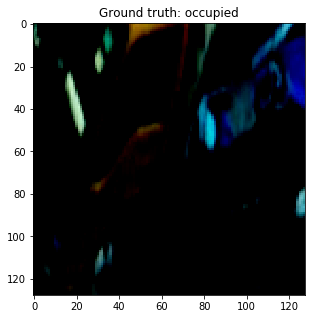

In [11]:
training_iters = 200
learning_rate = 0.001
batch_size = 128

In [13]:
# Both placeholders are of type float
x = tf.placeholder("float", [None, 128, 128, 3])
y = tf.placeholder("float", [None, 2])

In [14]:
def conv2d(x, W, b, strides=1):
    """Conv2D wrapper, with bias and relu activation."""
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

In [15]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

In [16]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [18]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [19]:
#Here you check whether the index of the maximum value of the predicted image is equal
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
# Initializing the variables
init = tf.global_variables_initializer()

In [23]:
with tf.Session() as sess:
    sess.run(init)
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))] 
            # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x, y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
              "{:.6f}".format(loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))
        print("Optimization Finished!")
        
        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.327325, Training Accuracy= 0.87500
Optimization Finished!
Testing Accuracy: 0.84800



KeyboardInterrupt



In [ ]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

In [ ]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy'
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()